# Data Collection

**Unzip stock to have access to files in notebook enviorment**
- using in google colab

In [6]:
!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip
!pip install h5py
import numpy as np
import pandas as pd
from statistics import mean
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import os
import sys
import zipfile

#importing required libraries for keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.utils import print_summary

zname = 'stocks.zip'

with zipfile.ZipFile(zname,'r') as zip_ref:
  zip_ref.extractall()

     / 696kB 5.8MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-lts_rwr9/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


**Import all information from quotes from their .csv's**'
- date', 'open', 'high', 'low', 'close', 'adjclose', 'volume' for each stock

In [0]:
# All lists and Dictionaries ordered from most recent to oldest
dfdic = {}
failed = []

# Date,Open,High,Low,Close,Adj Close,Volume
# 1980-12-12,0.513393,0.515625,0.513393,0.513393,0.023007,117258400
# 1980-12-15,0.488839,0.488839,0.486607,0.486607,null,43971200
# ...
dirpath = 'stocks/quotes'
for file in os.listdir(dirpath):
    symbol = os.path.splitext(file)[0]
    #print('Stock:',symbol)
    path = dirpath + '/' + file
    try:
      dfdic[symbol] = pd.read_csv(path)
      dfdic[symbol].Date = pd.to_datetime(dfdic[symbol].Date, format='%Y-%m-%d')
    except pd.errors.ParserError:
      failed.append(symbol)
      continue
    except AttributeError:
      failed.append(symbol)
      continue
  


# Calculations

##SMA

**Calculate Small Moving Averages using Pandas**
- return a dictionay where each key is the symbol and the value is a pandas DataFrame with the moving average for that day

In [0]:
sma_dic = {}

def calcSMA(period):
  global sma_dic 
  start = 0
  sma = 0
  for sym,val in dfdic.items():
    if not sym in sma_dic.keys():
      try:
        df = pd.DataFrame()
        df['Date'] = dfdic[sym]['Date']
      except KeyError:
        continue
    else:
      df = sma_dic[sym]
      
    #check if length of all closing values is bigger than the period
    val = val.loc[:,'Close'].copy()
    if val.size-period < 0:
      #print(val,"closing array length of:",val.size,"...expected ~",start+period-1)
      continue
    #get the SMA for each stock with pandas
    sma = val.rolling(window=period).mean()
    df[period] = sma
    
    #Add to temp dictionary with key being the symbol and value is SMA
    sma_dic[sym] = df
    


##EMA

**Calculate the Exponential Moving Average**
- return a dictionay where each key is the symbol and the value is a pandas DataFrame with the exponential moving averages for each day

In [0]:
ema_dic = {}

def calcEMA(period):
  global ema_dic 
  start = 0
  ema = 0

  for sym,val in dfdic.items():
    if not sym in ema_dic.keys():
      try:
        df = pd.DataFrame()
        df['Date'] = dfdic[sym]['Date']
      except KeyError:
        continue
    else:
      df = ema_dic[sym]
    
    #check if length of all closing values is bigger than the period
    val = val.loc[:,'Close'].copy()
    if val.size-period < 0:
      print(val,"closing array length of:",val.size,"...expected ~", start+period-1)
      continue
    #get the EMA using pandas
    ema = val.ewm(span=period, adjust=False).mean()
    df[period] = ema
    
    #add to dictionary with key being the symbol and value is a pandas DataFrame
    ema_dic[sym] = df


##Momentum

**Calculate Momentum**
- Need to do more research on what it is and how to use it

In [0]:
def getmom(period=3):
  #temp dictionary to return
  temp = {}
  title = str(period)+'_day_momentum'
  #each symbol and corresponding dataframe
  for sym,val in dfdic.items():
    df = pd.DataFrame()
    #calculate percent change between current and prior element
    df['pct'] = val.loc[:,'Close'].copy().pct_change()
    #if the pct is > 0, 1 else -1, which is momentum
    df['momentum'] = np.where(df['pct'] > 0, 1,-1)  
    #make the rows the date
    df[title] = df.momentum.rolling(period).mean()
    df.index = val.Date
    temp[sym] = df
    
  return temp

#momentum = getmom()

##**Machine Learning Model (v1.1)**
**Calculate Predictions**


In [0]:
one_yr = 254 #number of trade days in a year = 254 (ie 10 years)
predict_dic = {}
rms_dic = {}
avg_dif_dic = {}
avg_perc_dif_dic = {}

#all examples use AAPL
def predict_LSTM(symbol, pred_days):
  #pred_days = one_yr
  hist_days = 5 * pred_days
  title = 'stocks/models/' + symbol + '.h5'
  
  #make new dataframe with just date and close
  new_data = dfdic[symbol][['Date','Close']].tail(pred_days + hist_days)
    
  #setting index
  new_data = new_data.loc[new_data.Date.notnull()]
  new_data = new_data.loc[new_data.Close.notnull()]
  new_data.set_index('Date', drop=True, inplace=True)
  
  #creating train and test sets
  dataset = new_data.values
  
  train = dataset[0:-pred_days,:]
  valid = dataset[-pred_days:,:]

  #converting dataset into x_train and y_train
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(dataset)
    
  x_train, y_train = [], []
  for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
  x_train, y_train = np.array(x_train), np.array(y_train)

  #print('x_train shape before reshape: ', x_train.shape())
  x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    
  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(LSTM(units=50))
  model.add(Dense(1))
  
  print('Loading %s Data for %d years' %(symbol,(hist_days/pred_days)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  print_summary(model)
  model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=1) # THIS LINE TAKES FOREVER!!!!!!!
  
  # save the shit
  model.save(title)
  
  #predicting 246 values, using past 60 from the train data
  inputs = new_data[len(new_data) - len(valid) - 60:].values
  inputs = inputs.reshape(-1,1)
  inputs  = scaler.transform(inputs)
  
  X_test = []
  for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
  X_test = np.array(X_test)
  
  X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
  closing_price = model.predict(X_test)
  closing_price = scaler.inverse_transform(closing_price)
  

  #Results
  rms = np.sqrt(np.mean(np.power((valid-closing_price),2)))
  rms_dic[symbol] = rms
  #print('RMS Results: ', rms)
  
  #get predictions and add to table
  train = new_data[:-pred_days+1].copy()
  valid = new_data[-pred_days:].copy()
  valid['Predictions'] = closing_price
  #new_data = pd.concat([new_data, valid], sort=True)
  new_data['Predictions'] = valid['Predictions']
  
  #calculate difference and percent error
  new_data['Difference']  = new_data['Predictions'] - new_data['Close']
  new_data['Difference'] = new_data['Difference'].abs()
  new_data['% Error'] = (new_data['Difference'] / new_data['Close']) * 100
  
  #calculate average of difference and percent error
  avg_dif_error = new_data['Difference'].mean()
  avg_perc_error = new_data['% Error'].mean()
  
  #add averages to appropriate dictionaries
  avg_dif_dic[symbol] = avg_dif_error
  avg_perc_dif_dic[symbol] = avg_perc_error
  
  predict_dic[symbol] = new_data  

  
  
def reload_model():
  for file in os.listdir('stocks/models/'):
    tok = file.split('.')
    if tok[1] != 'h5':
      continue
    model = load_model(file)
    #predicting 246 values, using past 60 from the train data
    inputs = new_data[len(new_data) - len(valid) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)

    X_test = []
    for i in range(60,inputs.shape[0]):
      X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)


    #Results
    rms = np.sqrt(np.mean(np.power((valid-closing_price),2)))
    rms_dic[symbol] = rms
    #print('RMS Results: ', rms)

    #get predictions and add to table
    train = new_data[:-pred_days+1].copy()
    valid = new_data[-pred_days:].copy()
    valid['Predictions'] = closing_price
    #new_data = pd.concat([new_data, valid], sort=True)
    new_data['Predictions'] = valid['Predictions']

    #calculate difference and percent error
    new_data['Difference']  = new_data['Predictions'] - new_data['Close']
    new_data['Difference'] = new_data['Difference'].abs()
    new_data['% Error'] = (new_data['Difference'] / new_data['Close']) * 100

    #calculate average of difference and percent error
    avg_dif_error = new_data['Difference'].mean()
    avg_perc_error = new_data['% Error'].mean()

    #add averages to appropriate dictionaries
    avg_dif_dic[symbol] = avg_dif_error
    avg_perc_dif_dic[symbol] = avg_perc_error

    predict_dic[symbol] = new_data


#predict_LSTM('AAPL', one_yr)
#predict_dic['AAPL']

In [58]:
presentation_stocks = ['AAPL','MSFT','GOOGL','NFLX','MSI','AMD','AMZN','GE','NKE','F','CELG','ANTM','TEVA']
one_yr = 254

# make predictions for stocks in presentation_stocks
def predict_pres_stocks():
  i=1
  for sym in presentation_stocks:
    try:
      print('\n\n%d) ' %(i), end='')
      predict_LSTM(sym, one_yr)
      i+=1
    except IndexError:
      continue
    except KeyError:
      continue

# make predictions of all stocks
def predict_all_stocks():
  i=1
  for sym in dfdic.keys():
    try:
      print('\n\n%d) ' %(i), end='')
      predict_LSTM(sym, one_yr)
      i+=1
    except IndexError:
      continue
    except KeyError:
      continue  


predict_pres_stocks()



1) Loading AAPL Data for 5 years
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
1210/1210 [==============================] - 76s 63ms/step - loss: 0.0015


2) Loading MSFT Data for 5 years
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 60, 50)            10400     
__________________________________________________

# Graphing Library

##Close
**Graph Close**
- ax = axes on which to graph
- symbol = symbol of stock to graph
- period = length of moving average

In [0]:
def graph_close(ax, symbol, period):
  
  #take respective stock info
  df = dfdic[symbol].tail(period).copy()
  
  # see if it exists or not
  if symbol not in dfdic.keys():
    print('ERROR: symbol: \'%s\' does not exist'%(symbol))
    
  #convert dates to numbers
  df['Date'] = pd.to_datetime(df['Date'])
  df['Date'] = df['Date'].apply(mdates.date2num)
  
  #set xaxis label
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  #ax.xaxis.set_minor_locator(mdates.DayLocator(interval=10))
  ax.tick_params(axis='x', which='both', rotation=60)

  #ax.tick_params(which='major',width=1.0, length=9)
  #ax.tick_params(which='minor',width=.75, length=0)

  #legend and axis names
  ax.set_title(str(period) + ' day EMA and SMA: '+ symbol )
  ax.set_ylabel('Price')
  ax.set_xlabel('Date')

  #show grid and legend
  ax.grid(color='grey')
  ax.legend(loc='best')
  
  #set values
  x = df['Date']
  y = df['Close']
  
  #plot SMA
  ax.plot(x, y, color='royalblue', label='Close')

##SMA
**Graph SMA**
- ax = axes on which to graph
- symbol = symbol of stock to graph
- period = length of moving average

In [0]:
def graph_SMA(ax, symbol, period):
  

  # see if it exists or not
  if symbol not in sma_dic.keys():
    print('ERROR: symbol does not exist')
  
  calcSMA(period)

  #take respective stock info
  df = sma_dic[symbol].tail(period).copy()      
  
  #convert dates to numbers
  #df['Date'] = pd.to_datetime(df['Date'])
  #df['Date'] = df['Date'].apply(mdates.date2num)
  
  #set xaxis label
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  #ax.xaxis.set_minor_locator(mdates.DayLocator(interval=10))
  ax.tick_params(axis='x', which='both', rotation=60)

  #ax.tick_params(which='major',width=1.0, length=9)
  #ax.tick_params(which='minor',width=.75, length=0)

  #legend and axis names
  ax.set_ylabel('Price')
  ax.set_xlabel('Date')

  #show grid and legend
  ax.grid(color='grey')
  ax.legend(loc='best')
  
  #set values
  x = df['Date']
  y = df[period] 
  lbl = str(period) + 'd SMA'
  
  #plot SMA
  ax.plot(x, y, label=lbl)


##EMA
**Graph EMA**
- ax = axes on which to graph
- symbol = symbol of stock to graph
- period = length of moving average

In [0]:
def graph_EMA(ax, symbol, period):
  
  
  # see if it exists or not
  if symbol not in dfdic.keys():
    print('ERROR: symbol does not exist')
  
  calcEMA(period)
  
  #take respective stock info
  df = ema_dic[symbol].tail(period).copy()
      
  
  #convert dates to numbers
  df['Date'] = pd.to_datetime(df['Date'])
  df['Date'] = df['Date'].apply(mdates.date2num)
  
  #set xaxis label
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m-%d'))
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_minor_locator(mdates.DayLocator(interval=15))
  ax.tick_params(axis='x', which='both', rotation=60)

  ax.tick_params(which='major',width=1.0, length=9)
  ax.tick_params(which='minor',width=.75, length=0)

  #legend and axis names
  ax.set_ylabel('Price')
  ax.set_xlabel('Date')

  #show grid and legend
  ax.grid(color='grey')
  ax.legend(loc='best')
  
  #set values
  x = df['Date']
  y = df[period]
  lbl = str(period) + 'd EMA'
  
  #plot EMA
  ax.plot(x, y, label=lbl)
  


##OHLC
**Graph Candles**
- ax = axes on which to graph
- symbol = symbol of stock to graph
- period = length of moving average

In [0]:
def graph_candles(ax, symbol, period):
  #take respective stock info
  df = dfdic[symbol].tail(period).copy()
  
  # see if it exists or not
  if symbol not in dfdic.keys():
    print('ERROR: symbol does not exist')
  
  #convert dates to numbers
  df['Date'] = pd.to_datetime(df['Date'])
  df["Date"] = df["Date"].apply(mdates.date2num)
  
  #set xaxis label
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_minor_locator(mdates.DayLocator(interval=14))
  ax.tick_params(axis='x', which='both', rotation=60)

  ax.tick_params(which='major',width=1.0, length=9)
  ax.tick_params(which='minor',width=.75, length=0)

  #legend and axis names
  ax.set_title(str(period) + ' day EMA and SMA: '+ symbol )
  ax.set_ylabel('Price')
  ax.set_xlabel('Date')

  #show grid and legend
  ax.grid(color='grey')
  ax.legend(loc='best')
  
  #copy only OHLC
  ohlc = df[['Date', 'Open', 'High', 'Low','Close']].copy()
  
  #plot OHLC
  candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='g', colordown='r')
  

##Predictions
**Graph Predictions**
- ax = axes on which to graph
- symbol = symbol of stock to graph
- period = length predicted days

In [0]:
def graph_prediction(ax, symbol, pred_days):
  hist_days = 5 * pred_days
  
  #take respective stock info
  df = predict_dic[symbol].copy()
  print(df['Close'].head())
  #plot the results  
  df['Close'].head(-pred_days).plot(ax=ax, label='Historic Close', color='b')
  df['Close'].tail(pred_days).plot(ax=ax, label='Actual Close', color='r')
  df['Predictions'].tail(pred_days).plot(ax=ax, label='Predictions', color='g')
  
  #title and labels
  ax.set_title(symbol + ' Predictions')
  ax.set_ylabel('Price $')
  ax.set_xlabel('Date')
  
  #grid and legend
  ax.grid(color='grey')
  ax.legend(loc='best')
  
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_minor_locator(mdates.DayLocator(interval=14))
  ax.tick_params(axis='x', which='both', rotation=60)

  ax.tick_params(which='major',width=1.0, length=9)
  ax.tick_params(which='minor',width=.75, length=0)

  #display table
  #new_data_graph['Predictions'] = new_data_graph['Predictions']
  #new_data_graph.tail(60)
  

##**Graph All**

**Graph all Function**
- period = length of moving average
- sma = True if you want to graph it, default is False
- ema = True if you want to graph it, default is False
- candles = True if you want to graph it, default is False
- predict = True if you want to graph it, default is False

No handles with labels found to put in legend.


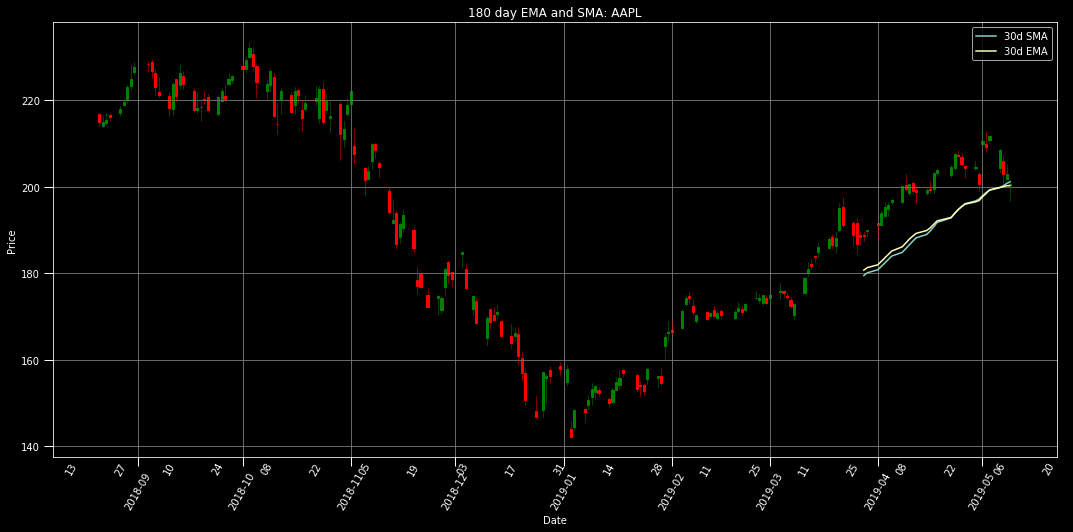

In [148]:
#plt.style.use('seaborn')
plt.style.use('dark_background')
#t1,t2,t3,t4,t5 = 0,0,0,0,0
def graph_all(symbol, close=[False,t1] , sma=[False,t2], ema=[False,t3], candles=[False,t4], predict=[False,t5]):
  if close[0] == True or sma[0] == True or ema[0] == True or candles[0] == True:
    f1, ax1 = plt.subplots(figsize = (18,8))
  if predict[0] == True:
    f2, ax2 = plt.subplots(figsize = (18,8))
  
  title = ''
  #create requested plots
  if close[0] == True:
    graph_close(ax1, symbol, close[1])
  if sma[0] == True:
    graph_SMA(ax1, symbol, sma[1])
  if ema[0] == True:
    graph_EMA(ax1, symbol, ema[1])
  if candles[0] == True:
    graph_candles(ax1, symbol, candles[1])
  if predict[0] == True:
    graph_prediction(ax2, symbol, predict[1])
    title = 'Predictions for ' + symbol
    ax2.set_title(title)
  
  plt.show()
  
  
#graph_all('AAPL', 200, close=True)
#graph_all('AAPL', 200, sma=True)
#graph_all('AAPL', 200, ema=True)
#graph_all('AAPL', 200, candles=True)
#graph_all('AAPL', 100, predict=True)

#graph_all('AAPL', 200, sma=True, ema=True, candles=True)
#graph_all('AAPL', 100, predict=True, close=True)
graph_all('AAPL', sma=[True,30] , ema=[True,30], candles=[True,180])


# **User Interface**

In [0]:
#predict_LTSM(symbol)
#for symbol in dfdic.keys():
#  predict_LTSM(symbol)

user_in = ''
cur_symbol = ''
df_ui = pd.DataFrame()
one_yr = 254 #number of trade days in a year = 254 (ie 10 years)

def mainmenu():
  print('=================================== MAIN MENU ===================================')
  print_mainMenu_help()
  
  while True:  
    user_in = input('> ').strip().upper()
    
    if user_in == 'HELP':
      print_mainMenu_help()
      
    elif user_in == 'EXIT' or 'QUIT':
      break
    
    tokens = user_in.split()
  
    if tokens[0] == 'MA':
      for i in tokens[1:]:
        try:
          calcSMA(int(i))
          calcEMA(int(i))
        except ValueError:
          print('INVALID ENTRY: %s is not an integer' %(i))
      print(' *** SUCCESS: SMA and EMA calculated')
      
    elif tokens[0] == 'PREDICT':
      try:
        predict_LTSM(cur_symbol, int(tokens[1]))
        print(' *** SUCCESS: Predictions calculated')
      except ValueError:
        print('INVALID ENTRY: %s is not an integer' %(i))
        
    elif tokens[0] == 'TABLE':
      if tokens[1] == 'MA':
        df_ui = concatDF(symbol)
        df_ui
      elif tokens[1] == 'PREDICT':
        df_ui = table_predict(cur_symbol)
        df_ui
      else:
        print('INVALID ENTRY: enter either ma or predict')
        
    elif tokens[0] == 'GRAPH':
      if tokens[1] == 'MA':
        graph_close_sma_ema(cur_symbol)
      elif tokens[1] == 'predict':
        graph_LTSM(cur_symbol, one_yr)
      else:
        print('INVALID ENTRY: enter either ma or predict')
        
    elif tokens[0] == 'CHANGE':
      if tokens[1] in dfdic.keys():
        cur_symbol = tokens[1]
        print(' *** SUCCESS: Stock changed to: %s' %(cur_symbol))
      else:
        print('INVALID ENTRY: symbol not stored in data')
      
    else:
      print('ERROR: invlaid command' %(user_in))
      
  print(' $$$ HAPPY TRADING $$$')
      
def print_mainMenu_help():
  if not cur_symbol == '': 
    print('\nCurrent Stock: %s' %(cur_symbol))
  else: 
    print('\nCurrent Stock: None')
    
  print('\t-- Calculate SMA & EMA ............... [ma period1 period2 ...]')
  print('\t-- Make predictions .................. [predict #daysfrom today]')
  print('\t-- Display SMA & EMA Table ........... [table ma]')
  print('\t-- Display predictions table ......... [table predict]')
  print('\t-- Graph SMA & EMA ................... [graph ma]')
  print('\t-- Graph predictions ................. [graph predict]')
  print('\t-- Change stocks ..................... [change symbol]')
  print('\t-- Help .............................. [help]')
  print('\t-- Exit .............................. [exit]')
  
  
  
#mainmenu()

##Evaluating Predictions

In [0]:
from datetime import datetime


for symbol in predict_dic.keys():
  predict_dic[symbol] = predict_dic[symbol].dropna()

headers = ['Projected Profit','Min','Max','Adj Min','Adj Max','Buy Date','Sell Date']
types = [float,float,float,float,float,datetime,datetime]
projections_df = pd.DataFrame(index=predict_dic.keys(), columns=headers)
#index=presentation_stocks, columns=['Profit','Min','Max','Buy Date','Sell Date']


#projections.columns = ['Profit','Min','Max','Buy Date','Sell Date']
#projections.index = presentation_stocks

#presentation_stocks
#predict_dic = {}
#rms_dic = {}
#avg_dif_dic = {}
#avg_perc_dif_dic = {}
  
def getminmax(symbol):
  df = predict_dic[symbol]
  minn = df['Predictions'].min(skipna=True)
  maxx = df['Predictions'].max(skipna=True)
  
  #Index(myseries).get_loc(7)
  #(myseries==7).argmax()
  #print('date min: %s' %(datetime.strf(df['Predictions'].argmin(), format='%Y-%m-%d')) )
  #print('date max: %s\n\n' %(datetime.strf(df['Predictions'].argmax(), format='%Y-%m-%d')) )
    
  return df['Predictions'].min(skipna=True), df['Predictions'].max(skipna=True)
  
def difMinMax(symbol, predict_min, predict_max):
  avg_dif = avg_dif_dic[symbol]
  return (predict_max - perc_dif ) - (pred_min + perc_dif)


def create_desirable_df():
  for symbol,df in predict_dic.items():
    df.dropna(how='any', inplace=True)
    tmp = projections_df.loc[symbol]
    predict_df = predict_dic[symbol]
    minn, maxx = getminmax(symbol)
    #dmin, dmax = getminmaxdate(minn,maxx)
    
    adj_min = minn + avg_dif_dic[symbol]
    adj_max = maxx - avg_dif_dic[symbol]
    
    tmp['Projected Profit'] = adj_max - adj_min
    tmp['Min'] = minn
    tmp['Max'] = maxx
    tmp['Adj Min'] = adj_min
    tmp['Adj Max'] = adj_max
    #tmp['Buy Date'] = datetime.strftime(df['Predictions'].argmin(), format='%Y-%m-%d')
    #tmp['Sell Date'] = datetime.strftime(df['Predictions'].argmax(), format='%Y-%m-%d')
    
    tmp['Buy Date'] = datetime.strftime(df[df['Predictions']==minn].index[0], format='%Y-%m-%d')
    tmp['Sell Date'] = datetime.strftime(df[df['Predictions']==maxx].index[0], format='%Y-%m-%d')
    
    #if dmin < dmax == True:
    
#projections_df['Buy Date'] = pd.to_datetime(projections_df['Buy Date'], format='%Y-%m-%d').copy()
#projections_df['Sell Date'] = pd.to_datetime(projections_df['Sell Date'], format='%Y-%m-%d').copy()

In [149]:

create_desirable_df()
projections_df = projections_df.sort_values(by='Projected Profit', ascending=False)
projections_df


,Projected Profit,Min,Max,Adj Min,Adj Max,Buy Date,Sell Date
AAPL,58.2455,151.962,221.007,157.362,215.607,2019-01-15,2018-10-08
MSFT,28.1812,94.7312,126.971,96.7603,124.942,2018-05-07,2019-05-07


#Dev Testing